# Session 5 - Model Selection and Regularization

### Contents

- [Subset Selection](#Subset-Selection)
- [Shrinkage Methods](#Shrinkage-Methods)
- [Principal Components Regression](#Principal-Components-Regression)
- [Partial Least Squares](#Partial-Least-Squares)

### Labs
- [Subset Selection methods](#Lab-1:-Subset-Selection-Methods)
- [Ridge Regression and the Lasso](#Lab-2:-Ridge-Regression-and-the-Lasso)
- [PCR and PLS Regression](#Lab-3:-PCR-and-PLS-Regression)

In [116]:
import pandas as pd
import numpy as np
import time
import itertools
import statsmodels.api as sm

from numpy.random import normal, uniform
from itertools import combinations
from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

## Subset Selection

In [3]:
# Credit ratings dataset
credit = pd.read_csv('data/Credit.csv', usecols=list(range(1,12)))

In [4]:
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [5]:
# X and y
X = credit.loc[:, credit.columns != 'Balance']
y = credit.loc[:,'Balance']

In [6]:
# Init RSS and R2
RSS = np.zeros((0,2))
R2 = np.zeros((0,2))

# Categorical variables 
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]

# Loop over all possible combinations of regressions
K = np.shape(X)[1]
for k in range(K+1):
    for i in combinations(range(K), k):
        
        # Subset X
        X_subset = X.iloc[:,list(i)]
        if k>0:
            cols = list(set(categ_cols) & set(X_subset.columns))
            X_subset = pd.get_dummies(X_subset, columns=cols, drop_first=True)

        # Regress
        reg = OLS(y,add_constant(X_subset)).fit()

        # Metrics
        r2 = np.reshape([k,reg.rsquared], (1,-1))
        R2 = np.append(R2, r2, axis=0)
        rss = np.reshape([k,reg.ssr], (1,-1))
        RSS = np.append(RSS, rss, axis=0)

In [7]:
# Save best scores
R2_best = [np.max(R2[R2[:,0]==k,1]) for k in range(K+1)]
RSS_best = [np.min(RSS[RSS[:,0]==k,1]) for k in range(K+1)]

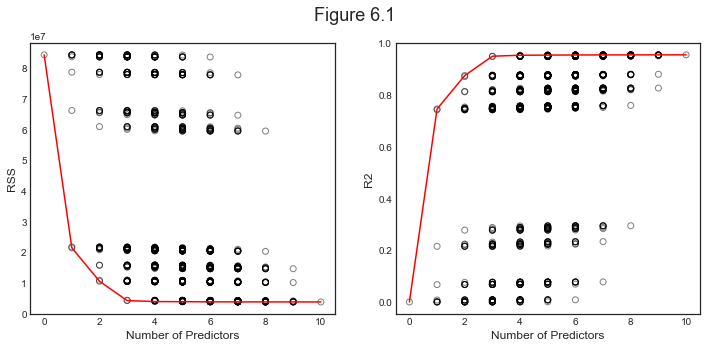

In [8]:
# Figure 6.1
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.1', fontsize=18)

# MSE
ax1.scatter(x=RSS[:,0], y=RSS[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax1.plot(range(K+1), RSS_best, c='r');
ax1.set_xlabel('Number of Predictors'); ax1.set_ylabel('RSS');

# R2
ax2.scatter(x=R2[:,0], y=R2[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax2.plot(range(K+1), R2_best, c='r');
ax2.set_xlabel('Number of Predictors'); ax2.set_ylabel('R2');

In [9]:
# Init metrics
AIC = np.zeros((0,2))
BIC = np.zeros((0,2))
R2_adj = np.zeros((0,2))

# Loop over all possible combinations of regressions
for k in range(K+1):
    for i in combinations(range(K), k):
        
        # Subset X
        X_subset = X.iloc[:,list(i)]
        if k>0:
            cols = list(set(categ_cols) & set(X_subset.columns))
            X_subset = pd.get_dummies(X_subset, columns=cols, drop_first=True)

        # Regress
        reg = OLS(y,add_constant(X_subset)).fit()

        # Advanced Metrics
        aic = np.reshape([k,reg.aic], (1,-1))
        AIC = np.append(AIC, aic, axis=0)
        bic = np.reshape([k,reg.bic], (1,-1))
        BIC = np.append(BIC, bic, axis=0)
        r2_adj = np.reshape([k,reg.rsquared_adj], (1,-1))
        R2_adj = np.append(R2_adj, r2_adj, axis=0)

In [10]:
# Save best scores
AIC_best = [np.min(AIC[AIC[:,0]==k,1]) for k in range(K+1)]
BIC_best = [np.min(BIC[BIC[:,0]==k,1]) for k in range(K+1)]
R2_adj_best = [np.max(R2_adj[R2_adj[:,0]==k,1]) for k in range(K+1)]

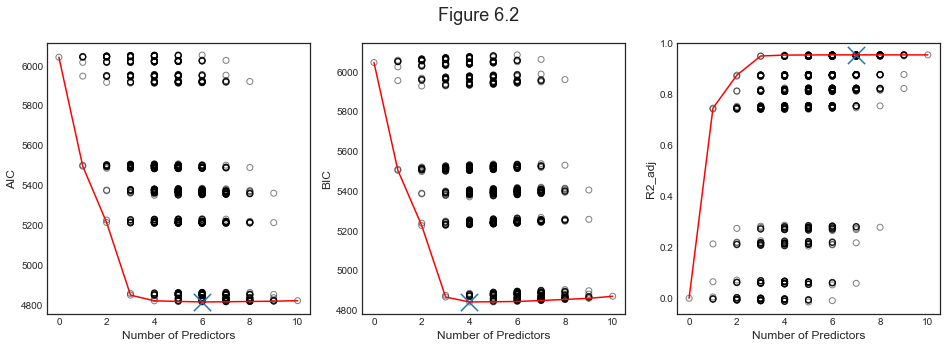

In [11]:
# Figure 6.2
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Figure 6.2', fontsize=18)

# AIC
ax1.scatter(x=AIC[:,0], y=AIC[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax1.plot(range(K+1),AIC_best, c='r');
ax1.scatter(np.argmin(AIC_best), np.min(AIC_best), marker='x', s=300)
ax1.set_xlabel('Number of Predictors'); ax1.set_ylabel('AIC');

# BIC
ax2.scatter(x=BIC[:,0], y=BIC[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax2.plot(range(K+1), BIC_best, c='r');
ax2.scatter(np.argmin(BIC_best), np.min(BIC_best), marker='x', s=300)
ax2.set_xlabel('Number of Predictors'); ax2.set_ylabel('BIC');

# R2 adj
ax3.scatter(x=R2_adj[:,0], y=R2_adj[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax3.plot(range(K+1), R2_adj_best, c='r');
ax3.scatter(np.argmax(R2_adj_best), np.max(R2_adj_best), marker='x', s=300)
ax3.set_xlabel('Number of Predictors'); ax3.set_ylabel('R2_adj');

## Shrinkage Methods

### Ridge Regression

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:

$$ 
\frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) 
$$

(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to

$$ 
\frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 
$$
    
The __sklearn Ridge()__ function optimizes:

$$ 
||X\beta - y||^2_2 + \alpha ||\beta||^2_2 
$$

which is equivalent to optimizing

$$ 
\frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 
$$

In [12]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = credit.loc[:,'Balance']
n = len(credit)

In [13]:
# Init alpha grid
n_grid = 100
alphas = 10**np.linspace(-2,5,n_grid).reshape(-1,1)
ridge = Ridge()
coefs = []

# Loop over values of alpha
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [14]:
# OLS regression
reg = LinearRegression().fit(scale(X),y)
ols_coefs = reg.coef_;

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

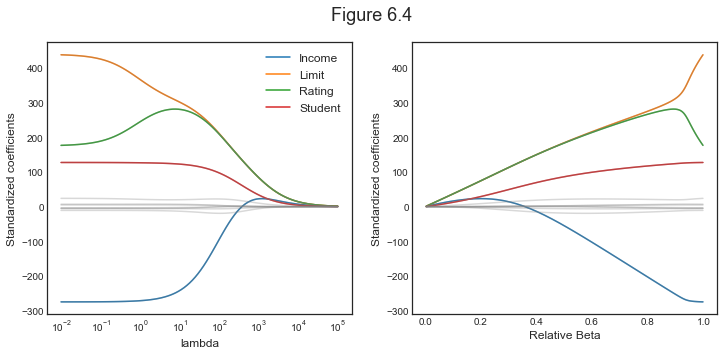

In [15]:
# Figure 6.4
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.4', fontsize=18)

highlight = [0,1,2,7];

# Plot coefficients - absolute
ax1.plot(alphas, coefs[:,highlight], alpha=1)
ax1.plot(alphas, coefs, c='grey', alpha=0.3)
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
ax1.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=12)

# Plot coefficients - relative
ax2.plot(rel_beta, coefs[:,highlight], alpha=1)
ax2.plot(rel_beta, coefs, c='grey', alpha=0.3)
ax2.set_xlabel('Relative Beta'); ax2.set_ylabel('Standardized coefficients');


The above plot shows that the Ridge coefficients get larger when we decrease alpha.

In [18]:
np.random.seed(3)

# Generate random data
n = 50
k = 45
k0 = k
X_train = normal(0,1,(n,k))
e_train = normal(0,k0**0.5,(n,1))
b0 = normal(0,1,(k0,1))

# y only depends on the first two columns
y_train = X_train[:,0:k0] @ b0 + e_train

# Test
X_test = normal(0,1,(n,k))
e_test = normal(0,k0**0.5,(n,1))
f_test = X_test[:,0:k0] @ b0
y_test = f_test + e_test

In [19]:
# Init alpha grid
n_grid = 100
df = pd.DataFrame({'alpha':10**np.linspace(-2,5,n_grid)})
coefs = []

# Loop over values of alpha
for i in range(len(df)):
    a = df.loc[i,'alpha']
    ridge = Ridge(alpha=a).fit(scale(X_train), y_train)
    y_hat = ridge.predict(scale(X_test))
    df.loc[i,'var'] = np.var(y_hat)
    df.loc[i,'mse'] = np.mean((y_test - y_hat)**2)
    df.loc[i,'bias2'] = df.loc[i,'mse'] - df.loc[i,'var'] - np.var(e_test)
    coefs.append(ridge.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [20]:
# OLS regression
reg = LinearRegression().fit(scale(X_train),y_train)
ols_coefs = reg.coef_;

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

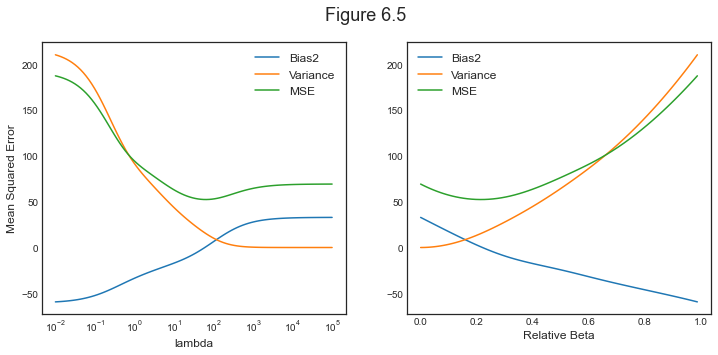

In [21]:
# Figure 6.4
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.5', fontsize=18)

# MSE
ax1.plot(df['alpha'], df[['bias2','var','mse']]);
ax1.set_xscale('log');
ax1.set_xlabel('lambda'); ax1.set_ylabel('Mean Squared Error');
ax1.legend(['Bias2','Variance','MSE'], fontsize=12);

# MSE
ax2.plot(rel_beta, df[['bias2','var','mse']]);
ax2.set_xlabel('Relative Beta'); ax1.set_ylabel('Mean Squared Error');
ax2.legend(['Bias2','Variance','MSE'], fontsize=12);

### 6.2.2 Lasso

In [22]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = credit.loc[:,'Balance']
n = len(credit)

In [24]:
# Init alpha grid
n_grid = 100
alphas = 10**np.linspace(0,3,n_grid).reshape(-1,1)
lasso = Lasso()
coefs = []

# Loop over values of alpha
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    coefs.append(lasso.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [25]:
# OLS regression
reg = LinearRegression().fit(scale(X),y)
ols_coefs = reg.coef_;

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

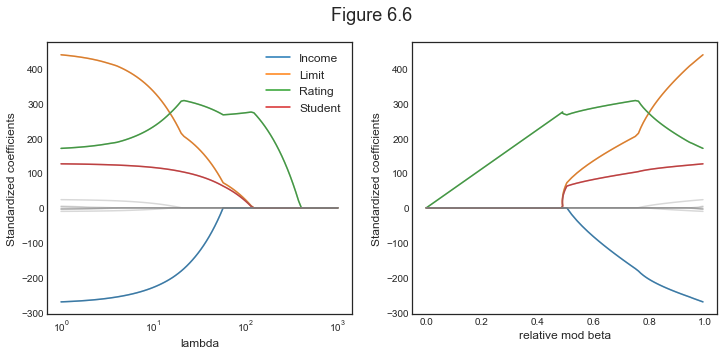

In [26]:
# Figure 6.6
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.6', fontsize=18)

highlight = [0,1,2,7];

# Plot coefficients - absolute
ax1.plot(alphas, coefs[:,highlight], alpha=1)
ax1.plot(alphas, coefs, c='grey', alpha=0.3)
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
ax1.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=12)

# Plot coefficients - relative
ax2.plot(rel_beta, coefs[:,highlight], alpha=1)
ax2.plot(rel_beta, coefs, c='grey', alpha=0.3)
ax2.set_xlabel('relative mod beta'); ax2.set_ylabel('Standardized coefficients');


In [27]:
# Init alpha grid
n_grid = 100
df = pd.DataFrame({'alpha':10**np.linspace(-1,1,n_grid)})
coefs = []

# Loop over values of alpha
for i in range(len(df)):
    a = df.loc[i,'alpha']
    lasso = Lasso(alpha=a).fit(scale(X_train), y_train)
    y_hat = lasso.predict(scale(X_test))
    df.loc[i,'var'] = np.var(y_hat)
    df.loc[i,'mse'] = np.mean((y_test - y_hat)**2)
    df.loc[i,'bias2'] = np.mean((y_hat - f_test)**2)
    df.loc[i,'bias2'] = df.loc[i,'mse'] - df.loc[i,'var'] - np.var(e_test)
    coefs.append(lasso.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [28]:
# OLS regression
ols_reg = LinearRegression().fit(scale(X_train),y_train)
ols_coefs = ols_reg.coef_;

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

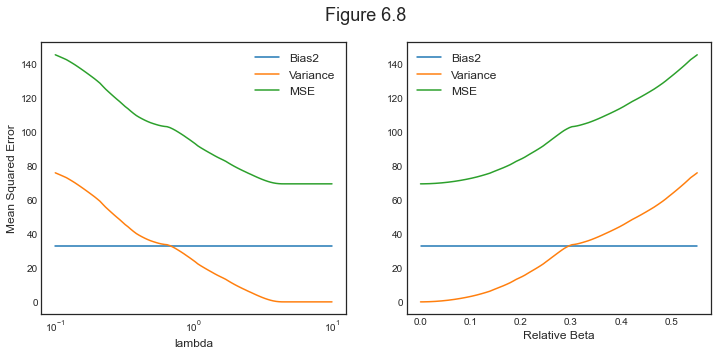

In [29]:
# Figure 6.8
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.8', fontsize=18)

# MSE
ax1.plot(df['alpha'], df[['bias2','var','mse']]);
ax1.set_xscale('log');
ax1.set_xlabel('lambda'); ax1.set_ylabel('Mean Squared Error');
ax1.legend(['Bias2','Variance','MSE'], fontsize=12);

# MSE
ax2.plot(rel_beta, df[['bias2','var','mse']]);
ax2.set_xlabel('Relative Beta'); ax1.set_ylabel('Mean Squared Error');
ax2.legend(['Bias2','Variance','MSE'], fontsize=12);

In [32]:
np.random.seed(3)

# Generate random data
n = 100
k = n
X = np.eye(k)
e = normal(0,1,(n,1))
b0 = uniform(-1,1,(k,1))
y = X @ b0 + e

In [33]:
# OLS regression
reg = LinearRegression().fit(X,y)
ols_coefs = reg.coef_;

# Ridge regression
ridge = Ridge(alpha=1).fit(X,y)
ridge_coefs = ridge.coef_;

# Ridge regression
lasso = Lasso(alpha=0.01).fit(X,y)
lasso_coefs = lasso.coef_.reshape(1,-1);

# sort
order = np.argsort(y.reshape(1,-1), axis=1)
y_sorted = np.take_along_axis(ols_coefs, order, axis=1) 
ols_coefs = np.take_along_axis(ols_coefs, order, axis=1) 
ridge_coefs = np.take_along_axis(ridge_coefs, order, axis=1) 
lasso_coefs = np.take_along_axis(lasso_coefs, order, axis=1) 

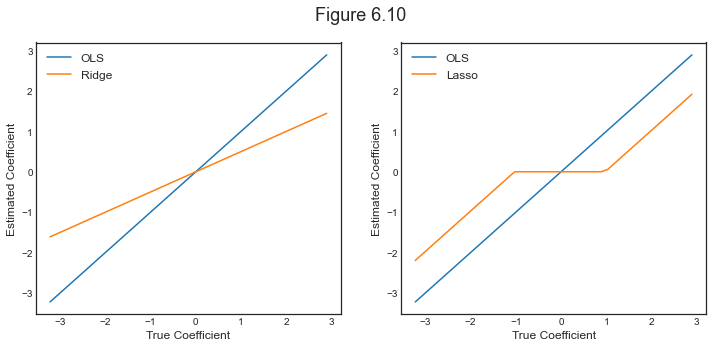

In [34]:
# Figure 6.10
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.10', fontsize=18)

# Ridge
ax1.plot(y_sorted.T, ols_coefs.T)
ax1.plot(y_sorted.T, ridge_coefs.T)
ax1.set_xlabel('True Coefficient'); ax1.set_ylabel('Estimated Coefficient');
ax1.legend(['OLS','Ridge'], fontsize=12);

# Lasso
ax2.plot(y_sorted.T, ols_coefs.T)
ax2.plot(y_sorted.T, lasso_coefs.T)
ax2.set_xlabel('True Coefficient'); ax2.set_ylabel('Estimated Coefficient');
ax2.legend(['OLS','Lasso'], fontsize=12);

### 6.2.3 Selecting the Tuning Parameter

In [35]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True).values
y = credit.loc[:,'Balance']
n = len(credit)

In [36]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

# Get Mse Function
def cv_ridge(X,y,a):
    mse = []
    # Generate splits
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    # Loop over splits
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        ridge = Ridge(alpha=a).fit(X_train, y_train)
        y_hat = ridge.predict(X_test)
        mse.append(mean_squared_error(y_test, y_hat))
    return np.mean(mse)

In [37]:
# Compute MSE over grid of alphas
# WARNING! takes time
n_grid = 30
alphas = 10**np.linspace(-3,1,n_grid).reshape(-1,1)
MSE = [cv_ridge(X,y,a) for a in alphas]

In [38]:
# Find minimum alpha
alpha_min = alphas[np.argmin(MSE)]
print('Best alpha by LOO CV:',alpha_min[0])

Best alpha by LOO CV: 0.16102620275609392


In [39]:
# Get coefficients
coefs = []

# Loop over values of alpha
for a in alphas:
    ridge = Ridge(alpha=a).fit(scale(X), y)
    coefs.append(ridge.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

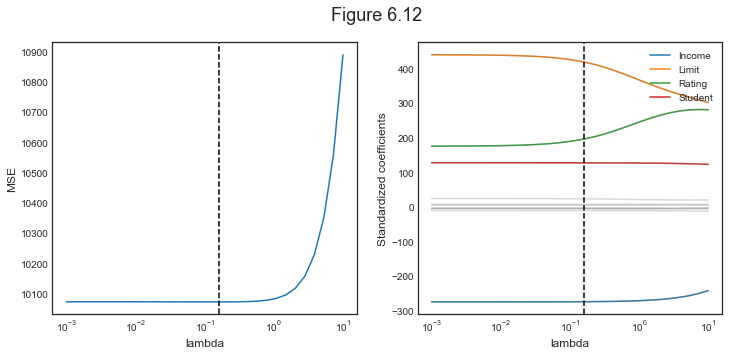

In [40]:
# Figure 6.12
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.12', fontsize=18)

# MSE by LOO CV
ax1.plot(alphas, MSE, alpha=1);
ax1.axvline(alpha_min, c='k', ls='--')
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('MSE');

highlight = [0,1,2,7];

# Plot coefficients - absolute
ax2.plot(alphas, coefs[:,highlight], alpha=1)
ax2.plot(alphas, coefs, c='grey', alpha=0.3)
ax2.axvline(alpha_min, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel('lambda'); ax2.set_ylabel('Standardized coefficients');
ax2.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=10);


# Labs

## Lab 1: Subset Selection Methods

### Lab1.1: Best Subset Selection

Here we apply the best subset selection approach to the Hitters data. We
wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year. Let's take a quick look:

In [41]:
hitters_df = pd.read_csv('data/Hitters.csv')
hitters_df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


First of all, we note that the `Salary` variable is missing for some of the
players. The `isnull()` function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a `TRUE` value
for any elements that are missing, and a `FALSE` value for non-missing elements.
The `sum()` function can then be used to count all of the missing elements:

In [42]:
print("Number of null values:", hitters_df["Salary"].isnull().sum())

Number of null values: 59


We see that `Salary` is missing for 59 players. The `dropna()` function
removes all of the rows that have missing values in any variable:

In [43]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the player names
hitters_df_clean = hitters_df.dropna().iloc[:,1:]

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_df_clean.shape)

# One last check: should return 0
print("Number of null values:", hitters_df_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 21)
Dimensions of modified data: (263, 20)
Number of null values: 0


In [44]:
dummies = pd.get_dummies(hitters_df_clean[['League', 'Division', 'NewLeague']])

y = hitters_df_clean.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = hitters_df_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

We can perform best subset selection by identifying the best model that contains a given number of predictors, where **best** is quantified using RSS. We'll define a helper function to outputs the best set of variables for
each model size:

In [45]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [46]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a `DataFrame` containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

In [47]:
# Could take quite awhile to complete...
# Shortened from 8 to 5
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,5):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 19 models on 1 predictors in 0.07494211196899414 seconds.
Processed 171 models on 2 predictors in 0.7033591270446777 seconds.
Processed 969 models on 3 predictors in 3.762333869934082 seconds.
Processed 3876 models on 4 predictors in 16.705241918563843 seconds.
Total elapsed time: 21.33211398124695 seconds.


Now we have one big `DataFrame` that contains the best models we've generated along with their RSS:

In [48]:
models_best

,RSS,model
1,4.321393e+07,<statsmodels.regression.linear_model.Regressio...
2,3.073305e+07,<statsmodels.regression.linear_model.Regressio...
3,2.941071e+07,<statsmodels.regression.linear_model.Regressio...
4,2.797678e+07,<statsmodels.regression.linear_model.Regressio...


If we want to access the details of each model, no problem! We can get a full rundown of a single model using the `summary()` function:

In [49]:
models_best.loc[2, "model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Thu, 22 Oct 2020   Prob (F-statistic):                    5.80e-82
Time:                        09:27:40   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.000       2.441       3.467
CRBI           0.6788      0.066     10.295      0.000       0.549       0.809
==============================================================================
Omnibus:                      117.551   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              654.612
Skew:                           1.729   Prob(JB):                    7.12e-143
Kurtosis:                       9.912   Cond. No.                         5.88
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This output indicates that the best two-variable model
contains only `Hits` and `CRBI`. To save time, we only generated results
up to the best 7-variable model. You can use the functions we defined above to explore as many variables as are desired.

In [50]:
# Show the best 19-variable model (there's actually only one)
getBest(19)["model"].summary()

Processed 1 models on 19 predictors in 0.010529041290283203 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Salary   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              54.64
Date:                Thu, 22 Oct 2020   Prob (F-statistic):                    1.31e-76
Time:                        09:27:40   Log-Likelihood:                         -1877.9
No. Observations:                 263   AIC:                                      3794.
Df Residuals:                     244   BIC:                                      3862.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
AtBat          -1.5975      0.600     -2.663      0.008      -2.779      -0.416
Hits            7.0330      2.374      2.963      0.003       2.357      11.709
HmRun           4.1210      6.229      0.662      0.509      -8.148      16.390
Runs           -2.3776      2.994     -0.794      0.428      -8.276       3.520
RBI            -1.0873      2.613     -0.416      0.678      -6.234       4.059
Walks           6.1560      1.836      3.352      0.001       2.539       9.773
Years           9.5196     10.128      0.940      0.348     -10.429      29.468
CAtBat         -0.2018      0.135     -1.497      0.136      -0.467       0.064
CHits           0.1380      0.678      0.204      0.839      -1.197       1.473
CHmRun         -0.1669      1.625     -0.103      0.918      -3.367       3.033
CRuns           1.5070      0.753      2.001      0.047       0.023       2.991
CRBI            0.7742      0.696      1.113      0.267      -0.596       2.144
CWalks         -0.7851      0.329     -2.384      0.018      -1.434      -0.137
PutOuts         0.2856      0.078      3.673      0.000       0.132       0.439
Assists         0.3137      0.220      1.427      0.155      -0.119       0.747
Errors         -2.0463      4.350     -0.470      0.638     -10.615       6.522
League_N       86.8139     78.463      1.106      0.270     -67.737     241.365
Division_W    -97.5160     39.084     -2.495      0.013    -174.500     -20.532
NewLeague_N   -23.9133     79.361     -0.301      0.763    -180.234     132.407
==============================================================================
Omnibus:                       97.217   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              626.205
Skew:                           1.320   Prob(JB):                    1.05e-136
Kurtosis:                      10.083   Cond. No.                     2.06e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Rather than letting the results of our call to the `summary()` function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value:

In [51]:
models_best.loc[2, "model"].rsquared

0.7614950002332872

Excellent! In addition to the verbose output we get when we print the summary to the screen, fitting the `OLM` also produced many other useful statistics such as adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [52]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
dtype: float64

As expected, the $R^2$ statistic increases monotonically as more
variables are included.

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will
help us decide which model to select. Note the `type="l"` option tells `R` to
connect the plotted points with lines:

Text(0, 0.5, 'BIC')

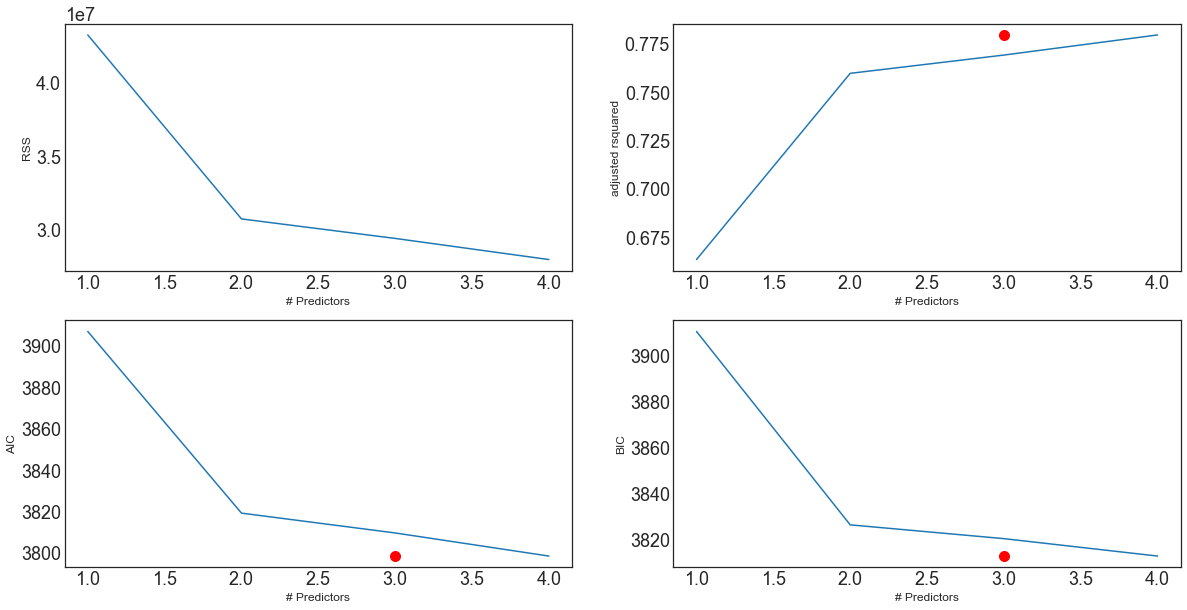

In [53]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Recall that in the second step of our selection process, we narrowed the field down to just one model on any $k<=p$ predictors. We see that according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted $R^2$ something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

### Lab1.2: Forward and Backward Stepwise Selection

We can also use a similar approach to perform forward stepwise
or backward stepwise selection, using a slight modification of the functions we defined above:

In [54]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

Now let's see how much faster it runs!

In [55]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.08580398559570312 seconds.
Processed  18 models on 2 predictors in 0.14779019355773926 seconds.
Processed  17 models on 3 predictors in 0.0635230541229248 seconds.
Processed  16 models on 4 predictors in 0.06518983840942383 seconds.
Processed  15 models on 5 predictors in 0.05637001991271973 seconds.
Processed  14 models on 6 predictors in 0.10296487808227539 seconds.
Processed  13 models on 7 predictors in 0.054399967193603516 seconds.
Processed  12 models on 8 predictors in 0.05045509338378906 seconds.
Processed  11 models on 9 predictors in 0.04411792755126953 seconds.
Processed  10 models on 10 predictors in 0.061820030212402344 seconds.
Processed  9 models on 11 predictors in 0.03718209266662598 seconds.
Processed  8 models on 12 predictors in 0.035279035568237305 seconds.
Processed  7 models on 13 predictors in 0.0696561336517334 seconds.
Processed  6 models on 14 predictors in 0.027098894119262695 seconds.
Processed  5 models on 15 predi

Phew! That's a lot better. Let's take a look:

In [63]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.665
Model:                            OLS   Adj. R-squared (uncentered):              0.663
Method:                 Least Squares   F-statistic:                              519.2
Date:                Thu, 22 Oct 2020   Prob (F-statistic):                    4.20e-64
Time:                        09:28:10   Log-Likelihood:                         -1952.4
No. Observations:                 263   AIC:                                      3907.
Df Residuals:                     262   BIC:                                      3910.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We see that using forward stepwise selection, the best one-variable
model contains only `Hits`, and the best two-variable model additionally
includes `CRBI`. Let's see how the models stack up against best subset selection:

In [67]:
models_best.loc[3, "model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Salary   R-squared (uncentered):                   0.772
Model:                            OLS   Adj. R-squared (uncentered):              0.769
Method:                 Least Squares   F-statistic:                              293.0
Date:                Thu, 22 Oct 2020   Prob (F-statistic):                    4.43e-83
Time:                        09:28:46   Log-Likelihood:                         -1901.8
No. Observations:                 263   AIC:                                      3810.
Df Residuals:                     260   BIC:                                      3820.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           3.4057      0.288     11.842      0.000       2.839       3.972
CRBI           0.6964      0.065     10.742      0.000       0.569       0.824
Division_W  -129.1604     37.777     -3.419      0.001    -203.548     -54.773
==============================================================================
Omnibus:                      110.025   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              621.594
Skew:                           1.589   Prob(JB):                    1.05e-135
Kurtosis:                       9.828   Cond. No.                         856.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
models_fwd.loc[4, "model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Salary   R-squared (uncentered):                   0.783
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              233.5
Date:                Thu, 22 Oct 2020   Prob (F-statistic):                    1.29e-84
Time:                        09:28:47   Log-Likelihood:                         -1895.3
No. Observations:                 263   AIC:                                      3799.
Df Residuals:                     259   BIC:                                      3813.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           2.7578      0.333      8.293      0.000       2.103       3.413
CRBI           0.6844      0.063     10.789      0.000       0.559       0.809
Division_W  -135.9724     36.963     -3.679      0.000    -208.758     -63.187
PutOuts        0.2755      0.076      3.643      0.000       0.127       0.424
==============================================================================
Omnibus:                      106.407   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              647.169
Skew:                           1.497   Prob(JB):                    2.95e-141
Kurtosis:                      10.077   Cond. No.                     1.01e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.

#### Backward Selection

Not much has to change to implement backward selection... just looping through the predictors in reverse!

In [69]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [70]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 18 predictors in 0.08855175971984863 seconds.
Processed  18 models on 17 predictors in 0.11224889755249023 seconds.
Processed  17 models on 16 predictors in 0.06334805488586426 seconds.
Processed  16 models on 15 predictors in 0.061627864837646484 seconds.
Processed  15 models on 14 predictors in 0.06698489189147949 seconds.
Processed  14 models on 13 predictors in 0.0715019702911377 seconds.
Processed  13 models on 12 predictors in 0.07284307479858398 seconds.
Processed  12 models on 11 predictors in 0.08127903938293457 seconds.
Processed  11 models on 10 predictors in 0.09083318710327148 seconds.
Processed  10 models on 9 predictors in 0.04848980903625488 seconds.
Processed  9 models on 8 predictors in 0.038469791412353516 seconds.
Processed  8 models on 7 predictors in 0.04826712608337402 seconds.
Processed  7 models on 6 predictors in 0.0277860164642334 seconds.
Processed  6 models on 5 predictors in 0.024020910263061523 seconds.
Processed  5 models on 4 pre

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.
However, the best seven-variable models identified by forward stepwise selection,
backward stepwise selection, and best subset selection are different:

In [75]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[2, "model"].params)

------------
Best Subset:
------------
Hits    2.953804
CRBI    0.678771
dtype: float64


In [76]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[3, "model"].params)

-----------------
Foward Selection:
-----------------
Hits            3.405706
CRBI            0.696362
Division_W   -129.160367
dtype: float64


In [77]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[4, "model"].params)

-------------------
Backward Selection:
-------------------
AtBat     -1.473144
Hits       7.323383
CRuns      0.672993
PutOuts    0.330127
dtype: float64


### Lab 1.3: Choosing Among Models Using the Validation Set Approach and Cross-Validation

#### Model selection using the Validation Set Approach

In Lab 8, we saw that it is possible to choose among a set of models of different
sizes using $C_p$, BIC, and adjusted $R^2$. We will now consider how to do this
using the validation set and cross-validation approaches.

As in Lab 8, we'll be working with the `Hitters` dataset from `ISLR`. Since we're trying to predict `Salary` and we know from last time that some are missing, let's first drop all the rows with missing values and do a little cleanup:

In [78]:
df = pd.read_csv('data/Hitters.csv')

# Drop any rows the contain missing values, along with the player names
df = df.dropna().iloc[:,1:]

# Get dummy variables
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

# Extract independent variable
y = pd.DataFrame(df.Salary)

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In order for the validation set approach to yield accurate estimates of the test
error, we must use *only the training observations* to perform all aspects of
model-fitting — including variable selection. Therefore, the determination of
which model of a given size is best must be made using *only the training
observations*. This point is subtle but important. If the full data set is used
to perform the best subset selection step, the validation set errors and
cross-validation errors that we obtain will not be accurate estimates of the
test error.

In order to use the validation set approach, we begin by splitting the
observations into a training set and a test set. We do this by creating
a random vector, train, of elements equal to TRUE if the corresponding
observation is in the training set, and FALSE otherwise. The vector test has
a TRUE if the observation is in the test set, and a FALSE otherwise. Note the
`np.invert()` in the command to create test causes TRUEs to be switched to FALSEs and
vice versa. We also set a random seed so that the user will obtain the same
training set/test set split.

In [79]:
np.random.seed(seed=12)
train = np.random.choice([True, False], size = len(y), replace = True)
test = np.invert(train)

We'll define our helper function to outputs the best set of variables for each model size like we did in Lab 8. Note that we'll need to modify this to take in both test and training sets, because we want the returned error to be the **test** error:

In [80]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {"model":regr, "RSS":RSS}

And our function to perform forward selection:

In [81]:
def forward(predictors, X_train, y_train, X_test, y_test):
    
    results = []

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
        
    # Return the best model, along with some other useful information about the model
    return best_model

Now, we'll call our `forward()` function on the training set in order to perform forward selection for all model sizes:

In [82]:
models_train = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,len(X.columns)+1):    
    models_train.loc[i] = forward(predictors, X[train], y[train]["Salary"], X[test], y[test]["Salary"])
    predictors = models_train.loc[i]["model"].model.exog_names

Now let's plot the errors, and find the model that minimizes it:

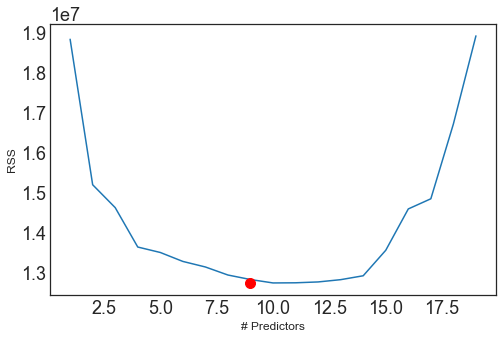

In [85]:
plt.plot(models_train["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_train["RSS"].argmin(), models_train["RSS"].min(), "or");

Viola! We find that the best model (according to the validation set approach) is the one that contains 10 predictors.

Now that we know what we're looking for, let's perform best subset selection on the full dataset and select the best 10-predictor model. It is important that we make use of the *full
data set* in order to obtain more accurate coefficient estimates. We perform this selection on the *full data set* and select the best 10-predictor
model, rather than simply using the predictors that we obtained
from the training set, because the best 10-predictor model on the full data
set may differ from the corresponding model on the training set.

In [86]:
models_test = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,11):    
    models_test.loc[i] = forward(predictors, X[test], y[test]["Salary"], X[test], y[test]["Salary"])
    predictors = models_test.loc[i]["model"].model.exog_names

In fact, we see that the best ten-variable model on the full data set has a
**different set of predictors** than the best ten-variable model on the training
set:

In [87]:
print(models_train.loc[10, "model"].model.exog_names)
print(models_test.loc[10, "model"].model.exog_names)

['Walks', 'CRBI', 'Hits', 'Division_W', 'CWalks', 'CRuns', 'AtBat', 'League_N', 'CHits', 'Runs']
['Walks', 'CRBI', 'Assists', 'Division_W', 'CWalks', 'CRuns', 'PutOuts', 'Errors', 'League_N', 'CHmRun']


#### Model selection using Cross-Validation

Now let's try to choose among the models of different sizes using cross-validation.
This approach is somewhat involved, as we must perform forward selection within each of the $k$ training sets. Despite this, we see that
with its clever subsetting syntax, `python` makes this job quite easy. First, we
create a vector that assigns each observation to one of $k = 10$ folds, and
we create a DataFrame in which we will store the results:

In [88]:
k = 10        # number of folds
np.random.seed(seed=1)
folds = np.random.choice(k, size = len(y), replace = True)

# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,20))
cv_errors = cv_errors.fillna(0)

Now let's write a for loop that performs cross-validation. In the $j^{th}$ fold, the
elements of folds that equal $j$ are in the test set, and the remainder are in
the training set. We make our predictions for each model size, compute the test errors on the appropriate subset,
and store them in the appropriate slot in the matrix `cv.errors`.

In [89]:
models_cv = pd.DataFrame(columns=["RSS", "model"])
    
# Outer loop iterates over all folds
for j in range(1,k+1):

    # Reset predictors
    predictors = []
    
    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)+1):    
    
        # The perform forward selection on the full dataset minus the jth fold, test on jth fold
        models_cv.loc[i] = forward(predictors, X[folds != (j-1)], y[folds != (j-1)]["Salary"], X[folds == (j-1)], y[folds == (j-1)]["Salary"])
        
        # Save the cross-validated error for this fold
        cv_errors[j][i] = models_cv.loc[i]["RSS"]

        # Extract the predictors
        predictors = models_cv.loc[i]["model"].model.exog_names
        

In [90]:
cv_errors

,1,2,3,4,5,6,7,8,9,10
1,3107900,3212304,4840103,2475453,3750302,1551976,1827366,9115194,1370720,2204862
2,2354036,2247881,3414444,1642455,3160950,1250564,1567469,8520751,1081052,1856304
3,2148733,2012864,3009435,1566581,2775618,907304,1260460,8456576,969784,1674333
4,1946031,1870511,2630784,1521525,2618750,805135,1143882,8331746,857553,1618265
5,1850398,1605148,2537690,1502728,2608466,776171,1124174,8221957,793919,1574253
6,1778324,1574266,2498621,1482575,2632055,776163,1115741,8196969,781235,1534220
7,1761111,1524413,2452303,1480345,2661104,779716,1104388,8171959,776457,1503831
8,1733230,1529625,2418943,1477510,2660654,803859,1100753,7449396,774589,1536790
9,1773705,1607919,2381843,1504519,2677002,821629,1096925,7136283,774616,1542746
10,1865909,1682293,2378624,1528102,2597881,854997,1136162,7059485,775993,1597314


This has filled up the `cv_errors` DataFrame such that the $(i,j)^{th}$ element corresponds
to the test MSE for the $i^{th}$ cross-validation fold for the best $j$-variable
model.  We can then use the `apply()` function to take the `mean` over the columns of this
matrix. This will give us a vector for which the $j^{th}$ element is the cross-validation
error for the $j$-variable model.

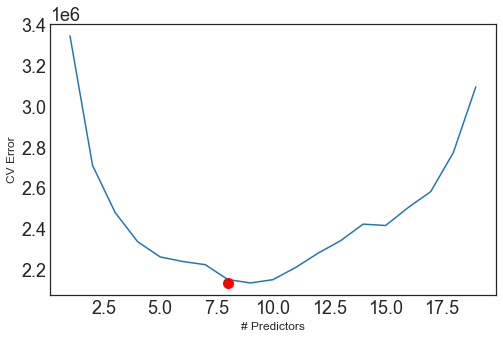

In [94]:
cv_mean = cv_errors.apply(np.mean, axis=1)

plt.plot(cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin(), cv_mean.min(), "or");

We see that cross-validation selects a 9-predictor model. Now let's go back to our results on the full data set in order to obtain the 9-predictor model.

In [95]:
models_cv.loc[9, "model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Salary   R-squared (uncentered):                   0.685
Model:                            OLS   Adj. R-squared (uncentered):              0.672
Method:                 Least Squares   F-statistic:                              54.56
Date:                Thu, 22 Oct 2020   Prob (F-statistic):                    8.32e-52
Time:                        09:29:54   Log-Likelihood:                         -1737.9
No. Observations:                 235   AIC:                                      3494.
Df Residuals:                     226   BIC:                                      3525.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           5.1036      2.325      2.195      0.029       0.522       9.686
PutOuts        0.2727      0.101      2.692      0.008       0.073       0.472
Division_W   -88.1122     50.742     -1.736      0.084    -188.101      11.876
HmRun         -0.8294      6.640     -0.125      0.901     -13.913      12.254
AtBat         -0.7780      0.667     -1.166      0.245      -2.093       0.537
League_N     103.4130     51.270      2.017      0.045       2.384     204.442
RBI            5.3063      3.007      1.764      0.079      -0.620      11.232
Assists        0.1477      0.281      0.525      0.600      -0.406       0.702
Errors        -9.2617      5.660     -1.636      0.103     -20.415       1.892
==============================================================================
Omnibus:                       62.044   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.556
Skew:                           1.123   Prob(JB):                     2.28e-40
Kurtosis:                       6.687   Cond. No.                     1.19e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For comparison, let's also take a look at the statistics from last lab:

Text(0, 0.5, 'BIC')

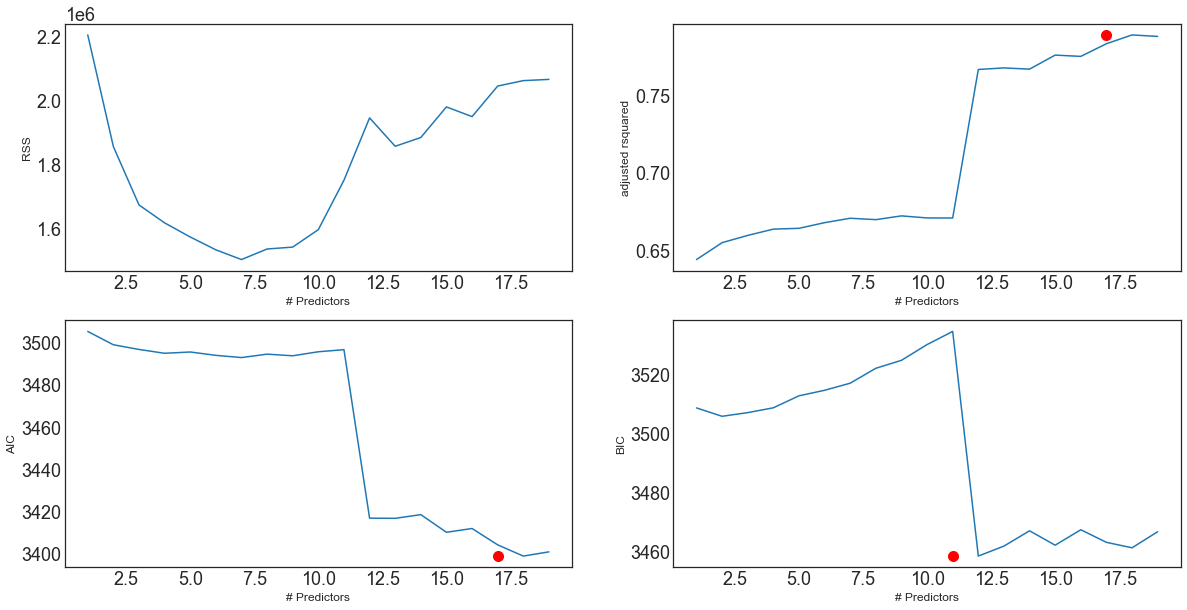

In [96]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_cv["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_cv.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_cv.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_cv.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC');

## Lab 2: Ridge Regression and the Lasso

We will use the `sklearn` package in order to perform ridge regression and
the lasso. The main functions in this package that we care about are `Ridge()`, which can be used
to fit ridge regression models, and `Lasso()` which will fit lasso models. They also have cross-validated counterparts: `RidgeCV()` and `LassoCV()`. We'll use these a bit later.

Before proceeding, let's first ensure that the missing values have
been removed from the data, as described in the previous lab.

In [97]:
df = pd.read_csv('data/Hitters.csv').dropna().iloc[:,1:]
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

We will now perform ridge regression and the lasso in order to predict `Salary` on
the `Hitters` data. Let's set up our data:

In [98]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    uint8  
 17  Division_W   263 non-null    uint8  
 18  NewLeague_N  263 non-null    uint8  
dtypes: float

### Lab 2.1: Ridge Regression

The `Ridge()` function has an alpha argument ($\lambda$, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially
covering the full range of scenarios from the null model containing
only the intercept, to the least squares fit:

In [99]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

Associated with each alpha value is a vector of ridge regression coefficients, which we'll
store in a matrix `coefs`. In this case, it is a $19 \times 100$
matrix, with 19 rows (one for each predictor) and 100
columns (one for each value of alpha). Remember that we'll want to standardize the
variables so that they are on the same scale. To do this, we can use the
`normalize = True` parameter:

In [100]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 19)

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,
when a large value of alpha is used, as compared to when a small value of alpha is
used. Let's plot and find out:

Text(0, 0.5, 'weights')

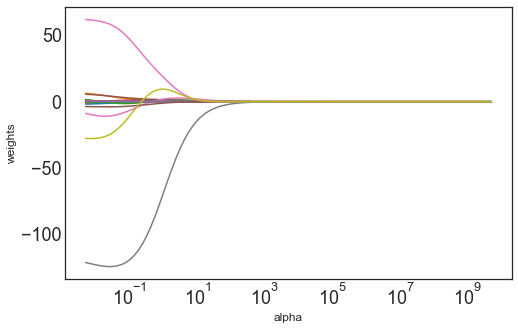

In [101]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso:

In [102]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

Next we fit a ridge regression model on the training set, and evaluate
its MSE on the test set, using $\lambda = 4$:

In [103]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

AtBat           0.098658
Hits            0.446094
HmRun           1.412107
Runs            0.660773
RBI             0.843403
Walks           1.008473
Years           2.779882
CAtBat          0.008244
CHits           0.034149
CHmRun          0.268634
CRuns           0.070407
CRBI            0.070060
CWalks          0.082795
PutOuts         0.104747
Assists        -0.003739
Errors          0.268363
League_N        4.241051
Division_W    -30.768885
NewLeague_N     4.123474
dtype: float64
106216.52238005561


The test MSE when alpha = 4 is 106216. Now let's see what happens if we use a huge value of alpha, say $10^{10}$:

In [104]:
ridge3 = Ridge(alpha = 10**10, normalize = True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))          # Calculate the test MSE

AtBat          1.317464e-10
Hits           4.647486e-10
HmRun          2.079865e-09
Runs           7.726175e-10
RBI            9.390640e-10
Walks          9.769219e-10
Years          3.961442e-09
CAtBat         1.060533e-11
CHits          3.993605e-11
CHmRun         2.959428e-10
CRuns          8.245247e-11
CRBI           7.795451e-11
CWalks         9.894387e-11
PutOuts        7.268991e-11
Assists       -2.615885e-12
Errors         2.084514e-10
League_N      -2.501281e-09
Division_W    -1.549951e-08
NewLeague_N   -2.023196e-09
dtype: float64
172862.23580379886


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test
MSE than fitting a model with just an intercept. We now check whether
there is any benefit to performing ridge regression with alpha = 4 instead of
just performing least squares regression. Recall that least squares is simply
ridge regression with alpha = 0.

In [105]:
ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE

AtBat           -1.821115
Hits             4.259156
HmRun           -4.773401
Runs            -0.038760
RBI              3.984578
Walks            3.470126
Years            9.498236
CAtBat          -0.605129
CHits            2.174979
CHmRun           2.979306
CRuns            0.266356
CRBI            -0.598456
CWalks           0.171383
PutOuts          0.421063
Assists          0.464379
Errors          -6.024576
League_N       133.743163
Division_W    -113.743875
NewLeague_N    -81.927763
dtype: float64
116690.46856660132


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha $ = 4$, it would be better to
use cross-validation to choose the tuning parameter alpha. We can do this using
the cross-validated ridge regression function, `RidgeCV()`. By default, the function
performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the
argument `cv`.

In [106]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.5748784976988678

Therefore, we see that the value of alpha that results in the smallest cross-validation
error is 0.57. What is the test MSE associated with this value of
alpha?

In [107]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

99825.6489629273

This represents a further improvement over the test MSE that we got using
alpha $ = 4$. Finally, we refit our ridge regression model on the full data set,
using the value of alpha chosen by cross-validation, and examine the coefficient
estimates.

In [108]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

AtBat           0.055838
Hits            0.934879
HmRun           0.369048
Runs            1.092480
RBI             0.878259
Walks           1.717770
Years           0.783515
CAtBat          0.011318
CHits           0.061101
CHmRun          0.428333
CRuns           0.121418
CRBI            0.129351
CWalks          0.041990
PutOuts         0.179957
Assists         0.035737
Errors         -1.597699
League_N       24.774519
Division_W    -85.948661
NewLeague_N     8.336918
dtype: float64

As expected, none of the coefficients are exactly zero - ridge regression does not
perform variable selection!

### Lab 2.2: The Lasso

We saw that ridge regression with a wise choice of alpha can outperform least squares as well as the null model on the Hitters data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. In order to fit a lasso model, we'll use the `Lasso()` function; however, this time we'll need to include the argument `max_iter = 10000`. Other than that change, we proceed just as we did in fitting a ridge model:

Text(0, 0.5, 'weights')

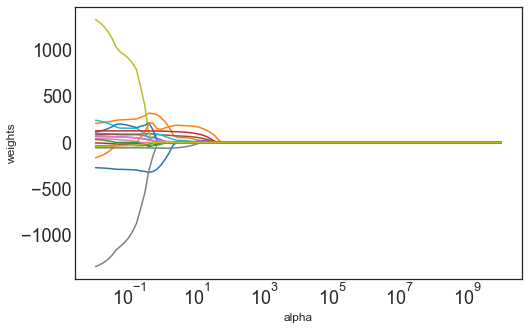

In [109]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [110]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

104960.65853895503

This is substantially lower than the test set MSE of the null model and of
least squares, and only a little worse than the test MSE of ridge regression with alpha
chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 13 of
the 19 coefficient estimates are exactly zero:

In [111]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat           0.000000
Hits            1.082446
HmRun           0.000000
Runs            0.000000
RBI             0.000000
Walks           2.906388
Years           0.000000
CAtBat          0.000000
CHits           0.000000
CHmRun          0.219367
CRuns           0.000000
CRBI            0.513975
CWalks          0.000000
PutOuts         0.368401
Assists        -0.000000
Errors         -0.000000
League_N        0.000000
Division_W    -89.064338
NewLeague_N     0.000000
dtype: float64

## Lab 3: PCR and PLS Regression

### Lab 3.1: Principal Components Regression

Principal components regression (PCR) can be performed using the `PCA()`
function, which is part of the `sklearn` library. In this lab, we'll apply PCR to the `Hitters`
data, in order to predict `Salary`. As in previous labs, we'll start by ensuring that the missing values have
been removed from the data:

In [112]:
df = pd.read_csv('data/Hitters.csv').dropna().iloc[:,1:]
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

Let's set up our data:

In [113]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

Unfortunately `sklearn` does not have an implementation of PCA and regression combined like the `pls`, package in R: https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf so we'll have to do it ourselves.

We'll start by performing Principal Components Analysis (PCA), remembering to scale the data:

In [117]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

Let's print out the first few variables of the first few principal components:

In [118]:
pd.DataFrame(pca.components_.T).loc[:4,:5]

,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


Now we'll perform 10-fold cross-validation to see how it influences the MSE:

In [119]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = KFold(n_splits=n, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

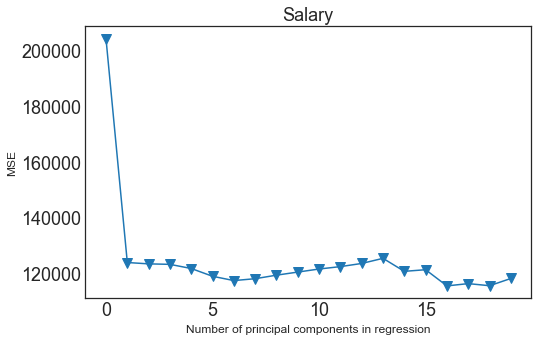

In [120]:
 # Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

We see that the smallest cross-validation error occurs when $M = 18$ components
are used. This is barely fewer than $M = 19$, which amounts to
simply performing least squares, because when all of the components are
used in PCR no dimension reduction occurs. However, from the plot we
also see that the cross-validation error is roughly the same when only one
component is included in the model. This suggests that a model that uses
just a small number of components might suffice.

We'll do a little math to get the amount of variance explained by adding each consecutive principal component:

In [121]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

We'll dig deeper into this concept in Chapter 10, but for now we can think of this as the amount of information about the predictors or the response that is captured using $M$ principal components. For example,
setting $M = 1$ only captures 38.31% of all the variance, or information, in
the predictors. In contrast, using $M = 6$ increases the value to 88.63%. If
we were to use all $M = p = 19$ components, this would increase to 100%.

Now let's perform PCA on the training data and evaluate its test set
performance:

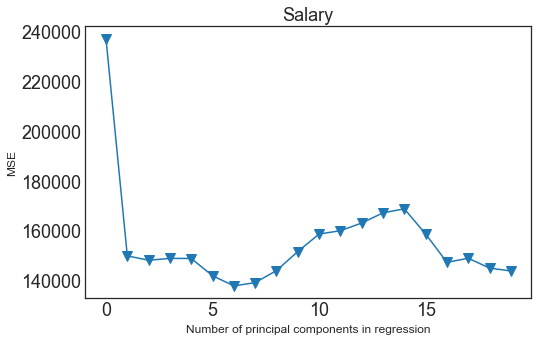

In [122]:
pca2 = PCA()

# Split into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

We find that the lowest cross-validation error occurs when $M = 6$
components are used. Now we'll see how it performs on the test data and compute the test MSE as follows:

In [123]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

111994.42273636989

This test set MSE is competitive with the results obtained using ridge regression
and the lasso. However, as a result of the way PCR is implemented,
the final model is more difficult to interpret because it does not perform
any kind of variable selection or even directly produce coefficient estimates.

### Lab 3.2: Partial Least Squares

Scikit-learn `PLSRegression` gives same results as the `pls` package in R when using `method='oscorespls'`. However, the standard method used is `'kernelpls'`, which we'll use here. Feel free to try out both.

In [124]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

(-1.0, 19.9)

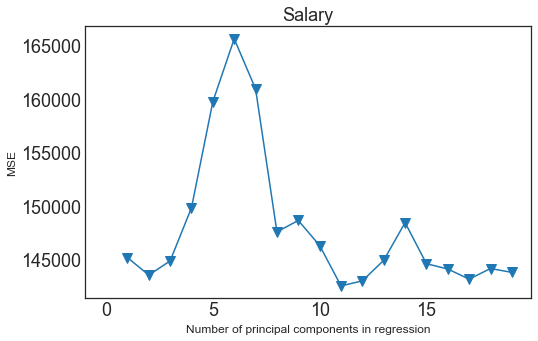

In [125]:
# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The lowest cross-validation error occurs when only $M = 2$ partial least
squares dimensions are used. We now evaluate the corresponding test set
MSE:

In [126]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

104838.51042760801

The test MSE is again comparable to the test MSE
obtained using ridge regression, the lasso, and PCR.

## Next Lecture

Jump to [Session 6 - Convexity and Optimization](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/6_convexity.ipynb)